In [3]:
import torch

data = torch.load('WiFiSensingDataset.pt')

In [16]:
print('data keys are:', data.keys())
print(f'train  subset has {len(data["X_train"])} samples')
print(f'test   subset has {len(data["X_test"])} samples')
print('data  shape is:', data['X_train'][0].shape)

num_unique_labels = len(torch.unique(data['y_train']))
print(f'Number of unique labels in the training set: {num_unique_labels}')

data keys are: dict_keys(['X_test', 'X_train', 'y_test', 'y_train'])
train  subset has 2500 samples
test   subset has 500 samples
data  shape is: torch.Size([1, 250, 90])
Number of unique labels in the training set: 7


In [17]:
print('unique labels are:', torch.unique(data['y_train']))

unique labels are: tensor([0., 1., 2., 3., 4., 5., 6.])


In [24]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class WiFiSensingDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx].long()

# Create an instance of the dataset
train_dataset = WiFiSensingDataset(data['X_train'], data['y_train'])
test_dataset = WiFiSensingDataset(data['X_test'], data['y_test'])

# load the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
#quick test for the dataloader
train_dataset[0]

(tensor([[[0.5931, 0.6234, 0.6664,  ..., 0.8558, 0.8676, 0.8395],
          [0.5971, 0.6378, 0.6707,  ..., 0.8611, 0.8697, 0.8310],
          [0.6177, 0.6463, 0.7014,  ..., 0.8671, 0.8882, 0.8355],
          ...,
          [0.5660, 0.6178, 0.6437,  ..., 0.8034, 0.8093, 0.7637],
          [0.5688, 0.5915, 0.6619,  ..., 0.8008, 0.8138, 0.7581],
          [0.5595, 0.6065, 0.6748,  ..., 0.8052, 0.8233, 0.7676]]]),
 tensor(2))

In [31]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 31 * 11, 128)
        self.fc2 = nn.Linear(128, )  # 10 output classes for CIFAR-10

    def forward(self, x):
        # original shape 1, 250, 90
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  #  16, 125, 45
        x = self.pool(self.relu(self.conv2(x)))  # 32, 62, 22 
        x = self.pool(self.relu(self.conv3(x)))  # 64, 31, 11 
        
        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4)
        
        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits
        
        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)


TypeError: Linear.__init__() missing 1 required positional argument: 'out_features'

In [32]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


In [33]:
import torch.optim as optim

# Initialize the model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 20 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 79/79 [00:02<00:00, 39.18it/s]


Epoch 1/20: Train Loss=0.1641, Train Accuracy=94.24%, Val Loss=0.3402, Val Accuracy=87.40%


100%|██████████| 79/79 [00:01<00:00, 42.27it/s]


Epoch 2/20: Train Loss=0.1414, Train Accuracy=95.48%, Val Loss=0.3088, Val Accuracy=90.20%


100%|██████████| 79/79 [00:01<00:00, 42.44it/s]


Epoch 3/20: Train Loss=0.0717, Train Accuracy=97.84%, Val Loss=0.3747, Val Accuracy=88.40%


100%|██████████| 79/79 [00:01<00:00, 42.87it/s]


Epoch 4/20: Train Loss=0.0523, Train Accuracy=98.48%, Val Loss=0.2632, Val Accuracy=91.20%


100%|██████████| 79/79 [00:01<00:00, 43.23it/s]


Epoch 5/20: Train Loss=0.0652, Train Accuracy=98.80%, Val Loss=0.3688, Val Accuracy=89.00%


100%|██████████| 79/79 [00:01<00:00, 43.43it/s]


Epoch 6/20: Train Loss=0.1170, Train Accuracy=96.72%, Val Loss=0.2635, Val Accuracy=91.20%


100%|██████████| 79/79 [00:01<00:00, 43.44it/s]


Epoch 7/20: Train Loss=0.0605, Train Accuracy=98.20%, Val Loss=0.2664, Val Accuracy=92.00%


100%|██████████| 79/79 [00:01<00:00, 43.05it/s]


Epoch 8/20: Train Loss=0.0627, Train Accuracy=97.96%, Val Loss=0.2055, Val Accuracy=92.60%


100%|██████████| 79/79 [00:01<00:00, 43.82it/s]


Epoch 9/20: Train Loss=0.0237, Train Accuracy=99.36%, Val Loss=0.1955, Val Accuracy=95.00%


100%|██████████| 79/79 [00:01<00:00, 43.77it/s]


Epoch 10/20: Train Loss=0.0209, Train Accuracy=99.48%, Val Loss=0.3293, Val Accuracy=91.40%


100%|██████████| 79/79 [00:01<00:00, 43.78it/s]


Epoch 11/20: Train Loss=0.0175, Train Accuracy=99.56%, Val Loss=0.2748, Val Accuracy=92.80%


100%|██████████| 79/79 [00:01<00:00, 43.81it/s]


Epoch 12/20: Train Loss=0.0062, Train Accuracy=99.88%, Val Loss=0.2125, Val Accuracy=95.00%


100%|██████████| 79/79 [00:01<00:00, 43.87it/s]


Epoch 13/20: Train Loss=0.0024, Train Accuracy=100.00%, Val Loss=0.2092, Val Accuracy=95.00%


100%|██████████| 79/79 [00:01<00:00, 43.76it/s]


Epoch 14/20: Train Loss=0.0018, Train Accuracy=100.00%, Val Loss=0.2308, Val Accuracy=94.80%


100%|██████████| 79/79 [00:01<00:00, 43.91it/s]


Epoch 15/20: Train Loss=0.0014, Train Accuracy=100.00%, Val Loss=0.2054, Val Accuracy=95.20%


100%|██████████| 79/79 [00:01<00:00, 43.88it/s]


Epoch 16/20: Train Loss=0.0011, Train Accuracy=100.00%, Val Loss=0.2207, Val Accuracy=95.00%


100%|██████████| 79/79 [00:01<00:00, 43.86it/s]


Epoch 17/20: Train Loss=0.0010, Train Accuracy=100.00%, Val Loss=0.2210, Val Accuracy=94.80%


100%|██████████| 79/79 [00:01<00:00, 43.98it/s]


Epoch 18/20: Train Loss=0.0015, Train Accuracy=100.00%, Val Loss=0.2360, Val Accuracy=95.00%


100%|██████████| 79/79 [00:01<00:00, 43.95it/s]


Epoch 19/20: Train Loss=0.0008, Train Accuracy=100.00%, Val Loss=0.2301, Val Accuracy=94.80%


100%|██████████| 79/79 [00:01<00:00, 43.92it/s]


Epoch 20/20: Train Loss=0.0007, Train Accuracy=100.00%, Val Loss=0.2383, Val Accuracy=95.00%


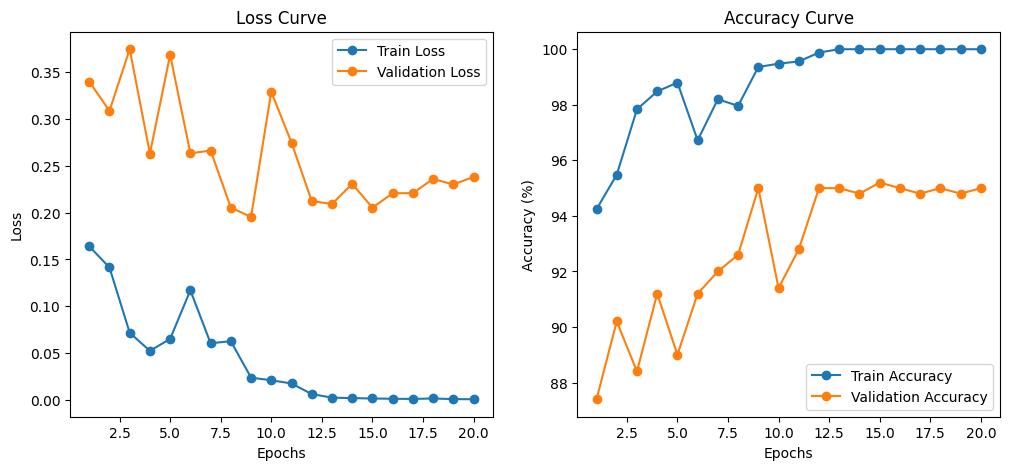

In [34]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()
